### B3DB xls -> tsvs
We convert Excel spreadsheets to a tsv's to facilitate access and prevent editing software from changing the values.
E.g. R49 logBB data not displaying decimal values, R9 including dates for compound names.

In [46]:
import collections
import os
import shelve
import statistics

import datamol
import pandas as pd
import rdkit

import urllib

from requests.adapters import HTTPAdapter, Retry

from functools import cache
from matplotlib import pyplot as plt

from matplotlib_venn import venn2
import requests_cache
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()
from rdkit.Chem import rdFingerprintGenerator
from utils import smiles_to_mol, get_tanimoto_distance, chembl_parent_from_smiles, smiles_to_fingerprint_tuple

In [3]:
references_kept = [
    "R3",
    "R4",
    "R5",
    "R6",
    "R7",
    "R12",
    "R14",
    # "R16", tested with the core set, adds 6 non-logBB.
    "R17",
    "R21",
    "R22",
    "R23",
    "R25",
    "R26",
    "R28",
    "R29",
    "R31",
    "R34",
    "R37",
    "R39",
    "R40",
    "R41",
    "R42",
    "R44",
    "R45",
    "R46",
    "R47",
    "R48",
    "R49",
    "R50",
]

references_used = references_kept + ["R51", "R52", "R53"]

references_id_to_first_author_year = {
    "R3": "abraham_2006",
    "R4": "mente_2005",
    "R5": "guerra_2008",
    "R6": "adenot_2004",
    "R7": "andres_2006",
    "R12": "garg_2006",
    "R14": "ghose_2012",
    "R17": "fu_2008",
    "R21": "muehlbacher_2011",
    "R22": "clark_1999",
    "R23": "gupta_2019",
    "R25": "brito_sanchez_2015",
    "R26": "chico_2009",
    "R28": "li_2005",
    "R29": "subramanian_2003",
    "R31": "carpenter_2014",
    "R34": "broccatelli_2012",
    "R37": "chen_2011",
    "R39": "shayanfar_2011",
    "R40": "vilar_2010",
    "R41": "toropov_2017",
    "R42": "ciura_2020",
    "R44": "bujak_2015",
    "R45": "hemmateenejad_2006",
    "R46": "mendoza_valencia_2017",
    "R47": "radchenko_2020",
    "R48": "hou_2003",
    "R49": "norinder_2002",
    "R50": "sobanska_2019",
    "R51": "doninger_2002", 
    "R52": "liu_2001", 
    "R53": "friden_2009"
}

def get_b3db_raw_df(id, b3db_raw_data_folder = os.path.join(os.getcwd(), "../data/B3DB/raw_data")):
    return pd.read_excel(os.path.join(b3db_raw_data_folder, id, "data_formatted_done.xls"))

def get_b3db_r_df(id, data_folder = os.path.join(os.getcwd(), "reference_data")):
    return pd.read_csv(os.path.join(data_folder, f"{id}.tsv"), sep="\t")

path_references_parsed = os.path.join(os.getcwd(), "reference_data")
if not os.path.exists(path_references_parsed):
    os.makedirs(path_references_parsed)

for r in references_kept:
    _df = get_b3db_raw_df(r)
    _out = os.path.join(path_references_parsed, f"{r}.tsv")
    
    # We need to sanitise line breaks early due to the format conversion. This functionality is duplicated during sanitisation.
    _df["compound_name"] = _df["compound_name"].apply(lambda x: str(x).replace("\n", "").replace("\r", ""))
    _df["smiles"] = _df["smiles"].apply(lambda x: str(x).replace("\n", ""))
    _df[["compound_name", "smiles", "CID", "logBB", "BBB+/BBB-"] + (["comments"] if "comments" in _df else [])].to_csv(_out, sep="\t", index=False)

## Record resolution
This section of the notebook includes the methods for extracting the raw data from the publication, cleaning it, resolving to unified PubChem entities, using ChEMBL pipeline to extract the "parent" structures and then normalising those to PubChem entities where available. 

The output of this step is a dataframe of all the records from all the publications, reconciled to the single "parent" structure.

In [4]:
def get_datasource_information():
    df_data_source_available_information = pd.read_csv(os.path.join(os.getcwd(), "../data",    "b3db_article_table_1_data_source_and_the_available_corresponding_information.tsv"), delimiter="\t")
    ds_info = []
    for d in df_data_source_available_information[["ID", "Data Source Size", "Information Available", "Data Type"]].to_dict("records"):
        d["Information Available"] = {
            "R40": "name, smiles",  # The data consists of several tables, the largest one includes SMILES.
            "R47": "name, smiles",
        }.get(d["ID"], d["Information Available"])
            
        # Filtering this data allows us to ignore over 400 BBB+ classifications from R26 where this data is not provided and molecules with logBB < -2 are labeled as BBB+.
        d["Data Type"] = {
            # Removed "R2": "numerical data",  # No categorical data present in the raw data sheet.
            "R26": "numerical data",  # All compounds classified as positive, original data does not include categories. While the spreadsheet is called "CNS-penetrant small molecules", the authors explicitly point out in the article that, for example, imatinib listed with logBB of -1.5 is not CNS-penetrant.
            "R34": "categorical data",  # Categorical and not numerical data is available.            
        }.get(d["ID"], d["Data Type"])
        ds_info.append(d)
    
    ds_info = ds_info + [
        {"ID": "R51", "Data Source Size": 325, "Information Available": "name", "Data Type": "categorical data"},
        {"ID": "R52", "Data Source Size": 70, "Information Available": "name, smiles", "Data Type": "numerical data"},
        {"ID": "R53", "Data Source Size": 42, "Information Available": "name", "Data Type": "numerical data"}
    ]     
    return ds_info

In [5]:
print("Provided  data types")
datatypes = []
for datasource in [d for d in get_datasource_information() if d["ID"] in references_used]:
    df_raw = get_b3db_r_df(datasource["ID"])
    
    
    nlbb = sum(pd.notna(df_raw.logBB))
    nlc_p = df_raw["BBB+/BBB-"].value_counts().get("BBB+")
    nlc_m = df_raw["BBB+/BBB-"].value_counts().get("BBB-")
    assert nlbb > 0 or "numerical data" not in datasource["Data Type"], "Should contain numerical data"

    assert nlc_p is not None or "categorical data" not in datasource["Data Type"], "Should contain categorical data, but does not."
    
    comment = ''
    if "categorical data" in datasource["Data Type"]:
        if nlc_p and nlc_p > 0 and nlc_m is None:
            comment += "Only positive category"
        if nlc_m and nlc_m > 0 and nlc_p is None:
            comment += "Only negative category"
    datatypes.append({
        "reference": datasource["ID"],
        "author_year": references_id_to_first_author_year[datasource["ID"]],
        "data_types": datasource["Data Type"],
        "comment": comment
    })
pd.DataFrame(datatypes)

Provided  data types


,reference,author_year,data_types,comment
0,R3,abraham_2006,numerical data,
1,R4,mente_2005,numerical data,
2,R5,guerra_2008,numerical data,
3,R6,adenot_2004,categorical data,
4,R7,andres_2006,categorical data,
5,R12,garg_2006,numerical data,
6,R14,ghose_2012,categorical data,
7,R17,fu_2008,numerical data,
8,R21,muehlbacher_2011,numerical data,
9,R22,clark_1999,numerical data,


In [6]:
@cache
def get_pubchem_session():
    path_cache = os.path.join(os.getcwd(), "caches" , "pubchem_session")
    session=requests_cache.CachedSession(path_cache, allowable_codes=[200], allowable_methods=["GET", "POST"])
    retries_adapter = HTTPAdapter(max_retries=Retry(total=5, backoff_factor=0.25))
    session.mount('http://', retries_adapter)
    session.mount('https://', retries_adapter)
    return session


QUERY_RESULT_SUCCESS = "Success"
QUERY_RESULT_ERROR = "Error, status code: "  # Add status code
QUERY_RESULT_NOT_FOUND = "Not found" #  Returned CID == 0, Pubchem does not always return 404 status code.
QUERY_RESULT_INVALID_RESPONSE = "Invalid response"  # PropertyTable not there.

def query_pubchem_compound_information(namespace, value):
    """
    :param namespace:  cid | name | smiles | inchi | sdf | inchikey | formula etc.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/{namespace}/property/CanonicalSMILES,IsomericSMILES,InchiKey,IUPACName,Title/json"
    body = f"{namespace}={urllib.parse.quote_plus(value)}"
    res = get_pubchem_session().post(url, body)

    if not res.ok:
        return None, QUERY_RESULT_ERROR + str(res.status_code)
    d = res.json()
    if "PropertyTable" in d:
        retval = [c for c in d["PropertyTable"]["Properties"] if c["CID"] != 0]
        if len(retval) == 0:
            return None, QUERY_RESULT_NOT_FOUND
        return retval, QUERY_RESULT_SUCCESS
    return None, QUERY_RESULT_INVALID_RESPONSE


PUBCHEM_SHELF_PATH = os.path.join(os.getcwd(), "caches",  "pubchem_compound_shelf")

def get_pubchem_compound_information(namespace, value, shelf_path = PUBCHEM_SHELF_PATH):
    with shelve.open(shelf_path) as shelf:
        key = f"{namespace}:{value}"
        if key not in shelf:
            qr = query_pubchem_compound_information(namespace, value)
            shelf[key] = qr
        return shelf[key][0]

# Example usage:
# get_pubchem_compound_information("name", "tipredane")
# get_pubchem_compound_information("smiles", "CCSC3(CCC4C2CCC1=CC(=O)C=CC1(C)C2(F)C(O)CC34C)SC")

In [7]:
# Occasionally PubChem's API will fail, we recommend at least a single re-run of the notebook after pruning errors from the cache. 
# _to_del = []
# with shelve.open(PUBCHEM_SHELF_PATH) as shelf:
#     for k, v in shelf.items():
#         if v[0] is None:
#             _to_del.append(k)
#     for td in _to_del:
#         del shelf[td]
        

In [8]:
def sanitise_smiles(smi):
    """Minium cleaning of the smiles string, asserting it can be converted to rdkit's Mol object"""
    if pd.isna(smi):
        return None
    smi = smi\
        .replace(" ", "")\
        .replace("\n", "")\
        .replace("(H)", "([H])") # There is a single case in the dataset where this is problematic: C(F)(F)(F)C(H)(H)OC=C.
    sanitised = smiles_to_mol(smi)
    return rdkit.Chem.MolToSmiles(sanitised) if sanitised else None


# The following mappings were introduced for the compounds where the mapping exists in the original B3DB but is no longer available in our method.
COMPOUND_RENAMES = {
    "FK506 (fujimycin)": "Fujimycin",  # R7
    "FLUDARABINEPHOSPHATE": "FLUDARABINE PHOSPHATE",  # R15
    "VASOPRESSIN": "argipressin",  # R15
    "Terbutylchlorambucil": "Chlorambucil-tertiary butyl ester", # R17
    "17-(dimethylaminoethylamino)-17-demethoxygeldamycin": "17-DMAG", # R20
    "Campthothecin": "Camptothecin", # R20
    "Aminocyclopentane Carboxylic Acid": "AminocyclopentaneCarboxylic Acid", # R20
    "carbamazepine-10, 11-epoxide": "Carbamazepine epoxide", # #R39, reverted to the original name (less hyphen)
    "6 (Ms-275)": "Ms-275",
    "HEPP (beta-ethyl-beta-hydroxybenzenepropanamide)": "beta-ethyl-beta-hydroxybenzenepropanamide",
    "desmethydesipramine (didesipramine or Desdimethylimipramine)": "didesipramine",
    "5-Butyl-5-ethyl barbituric acid (Butethal)": "Butethal",
    "propyl-4-aminobenzoate (risocaine)": "Risocaine",
    "Org5222 (asenapine)": "asenapine",
    "HEPP (beta-ethyl-beta-hydroxybenzenepropanamide) (3-hydroxy-3-phenylpentamide)": "3-hydroxy-3-phenylpentamide",
    "ethyl 4-aminobenzoate (benzocaine)": "benzocaine",
    "vitamine (alpha-tocopherol)": "vitamin e",
    "vitamine(alpha-tocopherol)": "vitamin e",
    "flumethasone21pivalate(flumetasone-pivalate)": "flumetasone-pivalate",
    "flumethasone21pivalate (flumetasone-pivalate)": "flumetasone-pivalate",
    "MSP (N-methylspiroperidol)": "N-methylspiroperidol",
    "isothamine(profenamine)": "profenamine",
    "isothamine (profenamine)": "profenamine",
    "methylprednisolone21hemisuccinate (methylprednisolone-hemisuccinate)": "methylprednisolone-hemisuccinate",
    "methylprednisolone21hemisuccinate(methylprednisolone-hemisuccinate)": "methylprednisolone-hemisuccinate",
    "misonidazolefluoro (Fluoromisonidazole)": "Fluoromisonidazole",
    "Misonidazolefluoro (Fluoromisonidazole)": "Fluoromisonidazole",
    "Misonidazolefluoro(Fluoromisonidazole)": "Fluoromisonidazole",
    "12dichlorotetrafluoroethane (cryofluorane)": "cryofluorane",
    "propene (propylene)": "propylene",
    "propyl-4-aminobenzoate (risocaine)": "risocaine",
    "scopolamide (scopolamine)": "scopolamine",
    "2methylthiophencyclidine (gacyclidine)": "gacyclidine",
    "7amphetaminoethyltheophylline (fenetylline)": "fenetylline",
    "cyclosporina (ciclosporin)": "cyclosporin",
    "neomycinbas2ethylbutyrate (framycetin)": "framycetin",
    "amdinocillinpivoxil (pivmecillinam)": "pivmecillinam",
    "α-hydroxyalprazolam (alpha-hydroxyalprazolam)": "alpha-hydroxyalprazolam",
    "SKF89124 (7-hydroxy ropinirole)": "7-hydroxy ropinirole",
    "5-butyl-5-ethyl barbituric acid (Butethal)": "Butethal",
    "5-heptyl-5-ethyl barbituric acid (5-ethyl-5-heptyl-1,3-diazinane-2,4,6-trione)": "5-ethyl-5-heptyl-1,3-diazinane-2,4,6-trione",
    "5-hexyl-5-ethyl barbituric acid (ortal)": "ortal",
    "5-methyl-5-ethyl barbituric acid (NSC 30403)": "NSC 30403",
    "5-propyl-5-ethyl barbituric acid (5-ethyl-5-propyl-1,3-diazinane-2,4,6-trione)": "5-ethyl-5-propyl-1,3-diazinane-2,4,6-trione",
    "desmethyldesipramine (didesipramine)": "didesipramine",
    "donezepil (donepezil)": "donepezil",
    "nor-2-chlorpromazine (didemethylchlorpromazine)": "didemethylchlorpromazine",
    "cloticasone(cloticasone-propionate)" : "cloticasone propionate", 
    "cloticasone (cloticasone-propionate)": "cloticasone propionate",
    "loteprednol(loteprednol-etabonate)": "loteprednol etabonate",
    "loteprednol (loteprednol-etabonate)": "loteprednol etabonate",
    "beclomethasonedipropionate(beclometasone-dipropionate)": "beclometasone dipropionate",
    "beclomethasonedipropionate (beclometasone-dipropionate)": "beclometasone dipropionate",
    "ticabesone(ticabesone-propionate)": "ticabesone-propionate",
    "ticabesone (ticabesone-propionate)": "ticabesone-propionate",
    "1,1,2-trichloroethane (vinyltrichloride)": "vinyltrichloride",
    "7 (CI-994)": "CI-994",
    "mikamycin (pristinamycin-ia)": "pristinamycin-ia",
    "cormethasoneacetate (cormetasone-acetate)": "cormetasone acetate", 
    "hydrocortisonecypionate (hydrocortisone-cipionate)": "hydrocortisone cypionate",
    "erythromycin-ethylcarbonate": "erythromycin ethylcarbonate",
    "AmphotericinB": "Amphotericin B",
    "Ivermectin 1a": "Ivermectin B1a",
    "PHENOBARBITAL/PHENOBARBITONE": "Phenobarbital",
}


def clean_name(name, datasource_source_id):
    if pd.isna(name):
        return None
    if name == "-":
        return None
    
    name = str(name).replace("\n", "").replace("\r", "").strip().replace("ﬂu", "flu")
    name = name.split("\r\n")[0]
    
    # In R9 and R36 there are cases of date conversion. The original names are, for example 5-69. After the manual inspection, they cannot be reconciled in PubChem and hence they are ignored. An alternative would be to replace them with the original names from the paper. 
    if name.endswith("00:00:00"):
        return None
    if name in COMPOUND_RENAMES:
        return COMPOUND_RENAMES.get(name, name)
    if "CID " in name:
        cid = name.split("CID ")[1].split(" ")[0].rstrip(")")
        return f"CID {cid}"
    if datasource_source_id in {"R1", "R30"} and "(" in name and "-(" not in name:
        name = name.replace("(", " (")
    name = name.split(" (")[0].rstrip(" ")
    return name

assert clean_name("vitamine (alpha-tocopherol)", "") == "vitamin e"
assert clean_name("caffeine  (1,3,7-Trimethylxanthine)", "") == "caffeine"
assert clean_name("Org32104 (CID 22154175)", "") == "CID 22154175"
assert clean_name("flumethasone21pivalate(flumetasone-pivalate)", "") == "flumetasone-pivalate"

# Similar to COMPOUND_RENAMES but for the cases where search by IUPAC name returns 404.
COMPOUND_NAME_MAPS = {
    "(4As,7R,7aR,12bS)-9-methoxy-3-methyl-1,2,4,5,6,7,7a,13-octahydro-4,12-methanobenzofuro[3,2-e]isoquinoline-4a,7-diol": 131770023 ,  # R20
    #"Nor-2-chlorpromazine (CID 74981)": 74981,  # R47:280
    "AI-9": 204104,  # R47:100
    "everolimus, RAD001": 6442177,# R26:183
    "3-bromocytisine":  9807561, # R46:351  - SMILES in the record 
    "alpha-(4-pyridyl-1-oxide)-N-tert-butylnitrone": 135532295, # R21:281 SMILES in the record
    #"CID 10451635 (2-(3'-Iodo-4'-aminophenyl)-6- hydroxybenzothiazole)": 10451635,
    # "phenyl-N-tert-butylnitrone (CID 10313352)": 10313352,
    #"Org32104 (CID 22154175)": 22154175,
    #"Org34167 (CID 9861160)": 9861160,
    #"Lin_train_55 (CID 23235109)": 23235109, 
}   


def get_pubchem_compound_by_smiles(smi):
    if pd.isna(smi):
        return None
    smi = smi.replace(" ", "").replace("\n", "")
    by_smiles = get_pubchem_compound_information("smiles", smi)
    if by_smiles:
        assert len(by_smiles) <= 1, f"by_smiles invalid length (should be 1): {by_smiles}"
        return by_smiles[0]
        

def _get_pubchem_compound_by_name(name):
    if pd.isna(name):
        return None
    if type(name) is not str:
        print("name", name)
    if "CID " in name:
        cid = name.split("CID ")[1].split(" ")[0].rstrip(")")
        return get_pubchem_compound_information("cid", cid)
    if name in COMPOUND_NAME_MAPS:
        return get_pubchem_compound_information("cid", str(COMPOUND_NAME_MAPS[name]))
    return get_pubchem_compound_information("name", name)

assert _get_pubchem_compound_by_name("AI-9")[0]["CID"] == 204104
assert _get_pubchem_compound_by_name("Org32104 (CID 22154175)")[0]["CID"] == 22154175
    
def resolve_ids(df, data_source_size, information_available, col_id, col_name, col_smiles):
    assert data_source_size == len(df), f"counts mismatch: expected {data_source_size}, found {len(df)}"

    df["pubchem_compound_by_id"] = df[col_id].apply(lambda x: get_pubchem_compound_information("cid", str(int(x)))[0] if pd.notna(x) else None) if "CID" in information_available else None

    df["pubchem_compound_by_structure"] = df[col_smiles].apply(get_pubchem_compound_by_smiles) if "smiles" in information_available else None
    
    df["pubchem_compounds_by_name"] = df[col_name].apply(_get_pubchem_compound_by_name) if "name" in information_available else None

    return df

In [9]:
%%time
df_all = pd.DataFrame()

for datasource in (d for d in get_datasource_information() if d["ID"] in references_used):
    print("Resolving CIDs for raw datasource:", datasource["ID"])
    information_available = datasource["Information Available"]
    
    df_raw = get_b3db_r_df(datasource["ID"])
    df_raw["reference"] = datasource["ID"]
    df_raw["cid_cleaned"] = None
    df_raw["smiles_sanitised"] = None
    df_raw["compound_name_cleaned"] = None
    df_raw["logBB_cleaned"] = None
    df_raw["BBB+/BBB-_cleaned"] = None
    if "CID" in information_available:
    # R10 and R16 originally use a padded CID1 notation, e.g. 'CID100000297' for Methane which we need to translate to '297'.  
        df_raw["cid_cleaned"] = df_raw["CID"].apply(lambda x: int(str(x).lstrip("1").lstrip("0"))) if datasource["ID"] in {"R10", "R16"} else df_raw["CID"]  
    if "smiles" in information_available:
        df_raw["smiles_sanitised"] =  df_raw["smiles"].apply(sanitise_smiles)
    if "name" in information_available:
        df_raw["compound_name_cleaned"] = df_raw.compound_name.apply(lambda x: clean_name(x, datasource["ID"]))
    
    if "numerical" in datasource["Data Type"]:
        df_raw["logBB_cleaned"] = df_raw["logBB"].apply(lambda x: round(float(str(x).replace("−", "-")), 2) if pd.notna(x) else None)
    if "categorical" in datasource["Data Type"]:
        df_raw["BBB+/BBB-_cleaned"] = df_raw["BBB+/BBB-"]
    
    df_resolved_ids = resolve_ids(df_raw, datasource["Data Source Size"], information_available, col_id="cid_cleaned", col_smiles="smiles_sanitised", col_name="compound_name_cleaned")
    
    print(list(df_all) == list(df_resolved_ids), df_resolved_ids.empty)
    df_all = pd.concat([df_all, df_resolved_ids])
df_all["record_id"] = list(map(lambda x: f"{x[1]}_{references_id_to_first_author_year[x[1]]}:{x[0]+1}", zip(df_all.index, df_all.reference)))
df_all = df_all.reset_index(drop=True)

# Last run 06/07/2024

Resolving CIDs for raw datasource: R3
False False
Resolving CIDs for raw datasource: R4
True False
Resolving CIDs for raw datasource: R5
True False
Resolving CIDs for raw datasource: R6
True False
Resolving CIDs for raw datasource: R7
True False
Resolving CIDs for raw datasource: R12


<timed exec>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
<timed exec>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


True False
Resolving CIDs for raw datasource: R14
True False
Resolving CIDs for raw datasource: R17
True False
Resolving CIDs for raw datasource: R21


<timed exec>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


False False
Resolving CIDs for raw datasource: R22
True False
Resolving CIDs for raw datasource: R23
True False
Resolving CIDs for raw datasource: R25


<timed exec>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


True False
Resolving CIDs for raw datasource: R26
True False
Resolving CIDs for raw datasource: R28
True False
Resolving CIDs for raw datasource: R29
True False
Resolving CIDs for raw datasource: R31
True False
Resolving CIDs for raw datasource: R34


<timed exec>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
<timed exec>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


True False
Resolving CIDs for raw datasource: R37
True False
Resolving CIDs for raw datasource: R39
True False
Resolving CIDs for raw datasource: R40


<timed exec>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
<timed exec>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


True False
Resolving CIDs for raw datasource: R41
True False
Resolving CIDs for raw datasource: R42
True False
Resolving CIDs for raw datasource: R44
True False
Resolving CIDs for raw datasource: R45
True False
Resolving CIDs for raw datasource: R46
True False
Resolving CIDs for raw datasource: R47
True False
Resolving CIDs for raw datasource: R48
True False
Resolving CIDs for raw datasource: R49
True False
Resolving CIDs for raw datasource: R50
True False
Resolving CIDs for raw datasource: R51
True False
Resolving CIDs for raw datasource: R52
True False
Resolving CIDs for raw datasource: R53
True False
CPU times: user 2.98 s, sys: 1.35 s, total: 4.33 s
Wall time: 5.53 s


<timed exec>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [10]:
NO_MATCH_FOUND = "No matches found"
NO_MATCH_FOUND_INVALID_SMILES = "No matches found, SMILES invalid"

MATCHED_BY_ID = "Matched by ID"
MATCHED_BY_STRUCTURE = "Matched by structure"
MATCHED_BY_NAME = "Matched by name"
MATCHED_BY_NAME_OTHER_MATCHES_AVAILABLE = "Matched by name, other name matches available"

MATCHED_BY_ID_STRUCTURE_AND_NAME = "Matched by ID, structure and name"

MATCHED_BY_ID_AND_STRUCTURE = "Matched by ID and structure"
CONFLICT_BETWEEN_ID_AND_STRUCTURE = "Conflict between ID and structure"

MATCHED_BY_ID_AND_NAME = "Matched by ID and name"
MATCHED_BY_ID_AND_NAME_OTHER_MATCHES_AVAILABLE = "Matched by ID and name, other name matches available"
CONFLICT_BETWEEN_ID_AND_NAME = "Conflict between ID and name"

MATCHED_BY_STRUCTURE_AND_NAME = "Matched by structure and name"
MATCHED_BY_STRUCTURE_AND_NAME_OTHER_MATCHES_AVAILABLE = "Matched by structure and name, other name matches available"

CONFLICT_BETWEEN_NAME_AND_STRUCTURE = "Conflict between name and structure"


def resolve_pubchem_id(by_id, by_structure, by_name, original_smiles, minimum_similarity):
    """
    original_smiles are here only for the NO_MATCH_FOUND_INVALID_SMILES check.
    minumum_similarity - (0-1) threshold of Tanimoto similarity measure  
    # This prioritises ID over structure 
    """
    if pd.notna(by_id):
        _matched_id_to_structure = by_id["CID"] == by_structure["CID"] or get_tanimoto_distance(by_id["CanonicalSMILES"], by_structure["CanonicalSMILES"]) >= minimum_similarity if pd.notna(by_structure) else False
        _matched_id_to_name = by_id["CID"] in {i["CID"] for i in by_name if get_tanimoto_distance(by_id["CanonicalSMILES"], i["CanonicalSMILES"]) >= minimum_similarity} if type(by_name) is list and len(by_name) > 0 else False
        
        if pd.notna(by_structure) and type(by_name) is list:
            if _matched_id_to_structure and _matched_id_to_name:
                return by_id["CID"], MATCHED_BY_ID_STRUCTURE_AND_NAME
        
        if pd.notna(by_structure):
            if _matched_id_to_structure:
                return by_id["CID"], MATCHED_BY_ID_AND_STRUCTURE
            else:
                return None, CONFLICT_BETWEEN_ID_AND_STRUCTURE        
        
        elif type(by_name) is list and len(by_name) > 0:
            by_name_tanimoto = sorted(
                [(
                    c_b_n,
                    get_tanimoto_distance(by_id["CanonicalSMILES"], c_b_n["CanonicalSMILES"])
                ) for c_b_n in by_name],
                key=lambda x: x[1],
                reverse=True
            )
            by_name_tanimoto_filtered = [b_n_t for b_n_t in by_name_tanimoto if b_n_t[1] >= minimum_similarity or b_n_t[0]["CID"] == by_id["CID"]]
            if len(by_name_tanimoto_filtered) == 0:
                return None, CONFLICT_BETWEEN_ID_AND_NAME
            for b_n_t_f in by_name_tanimoto_filtered:
                if b_n_t_f[0]["CID"] == by_id["CID"]:
                    return b_n_t_f[0]["CID"], MATCHED_BY_ID_AND_NAME

            return by_name_tanimoto_filtered[0][0]["CID"], MATCHED_BY_ID_AND_NAME
            
        return by_id["CID"], MATCHED_BY_ID
    
    
    if pd.notna(by_structure) and type(by_name) is list and len(by_name) > 0: 
        with datamol.without_rdkit_log():
            by_name_tanimoto = sorted(
                [(
                    c_b_n,
                    get_tanimoto_distance(by_structure["CanonicalSMILES"], c_b_n["CanonicalSMILES"])
                ) for c_b_n in by_name],
                key=lambda x: x[1],
                reverse=True
            )
            by_name_tanimoto_filtered = [b_n_t for b_n_t in by_name_tanimoto if b_n_t[1] >= minimum_similarity or b_n_t[0]["CID"] == by_structure["CID"]]
            if len(by_name_tanimoto_filtered) == 0:
                ### START parent structure / name match
                # There are 231 cases where the name refers to legitimate parent of the structure. E.g. Doxycycline R1:209 where structure matches 54684461 (doxycycline monohydrate) and conflicts with the name, parent points to 54671203. Of 22 cases in similar CID / Name mismatch there are no examples where this happens, therefore this addiitonal check is not included there. Ideally we could have this data in the dataframe, however to avoid circular setting (for some datapoints it is only after this step where we have the structure to extract parent) we do an odd call from within this loop. 
                # TODO check if parent molecule resolves by name.
                smi_parent, _ = chembl_parent_from_smiles(by_structure["CanonicalSMILES"])
                if smi_parent:
                    by_parent_structure = get_pubchem_compound_by_smiles(smi_parent)
                    if by_parent_structure:
                        by_name_parent_tanimoto = sorted([
                            (c_b_n, get_tanimoto_distance(smi_parent, c_b_n["CanonicalSMILES"])) 
                             for c_b_n in by_name
                        ], key=lambda x: x[1], reverse=True)

                        by_name_parent_tanimoto_filtered = [b_n_p_t[0] for b_n_p_t in by_name_parent_tanimoto if b_n_p_t[1] >= minimum_similarity or b_n_p_t[0]["CID"] == by_parent_structure["CID"]]
                        if len(by_name_parent_tanimoto_filtered) > 0:
                            matching_comment = MATCHED_BY_STRUCTURE_AND_NAME if len(by_name_parent_tanimoto_filtered) == 1 else MATCHED_BY_STRUCTURE_AND_NAME_OTHER_MATCHES_AVAILABLE if len(by_name_parent_tanimoto_filtered) > 1 else None
                            for b_n_t_p_f in by_name_parent_tanimoto_filtered:
                                if b_n_t_p_f["CID"] == by_parent_structure["CID"]:
                                    return b_n_t_p_f["CID"], matching_comment
                                return by_name_parent_tanimoto_filtered[0]["CID"], matching_comment
                ### END parent structure / name match     
                
                return None, CONFLICT_BETWEEN_NAME_AND_STRUCTURE

            matching_comment = MATCHED_BY_STRUCTURE_AND_NAME if len(by_name_tanimoto_filtered) == 1 else MATCHED_BY_STRUCTURE_AND_NAME_OTHER_MATCHES_AVAILABLE

            for b_n_t_f in by_name_tanimoto_filtered:
                if b_n_t_f[0]["CID"] == by_structure["CID"]:
                    return b_n_t_f[0]["CID"], matching_comment

            return by_name_tanimoto_filtered[0][0]["CID"], matching_comment
    elif pd.notna(by_id):
        return by_id["CID"], MATCHED_BY_ID
    elif pd.notna(by_structure):
        return by_structure["CID"], MATCHED_BY_STRUCTURE
    elif type(by_name) is list and len(by_name) > 0:
        return by_name[0]["CID"], MATCHED_BY_NAME
    elif pd.notna(original_smiles) and smiles_to_mol(original_smiles) is None:
        return None, NO_MATCH_FOUND_INVALID_SMILES
    else:
        return None, NO_MATCH_FOUND

### Effect of using different minimum similarity to reconcile between structure and name matches form PubChem

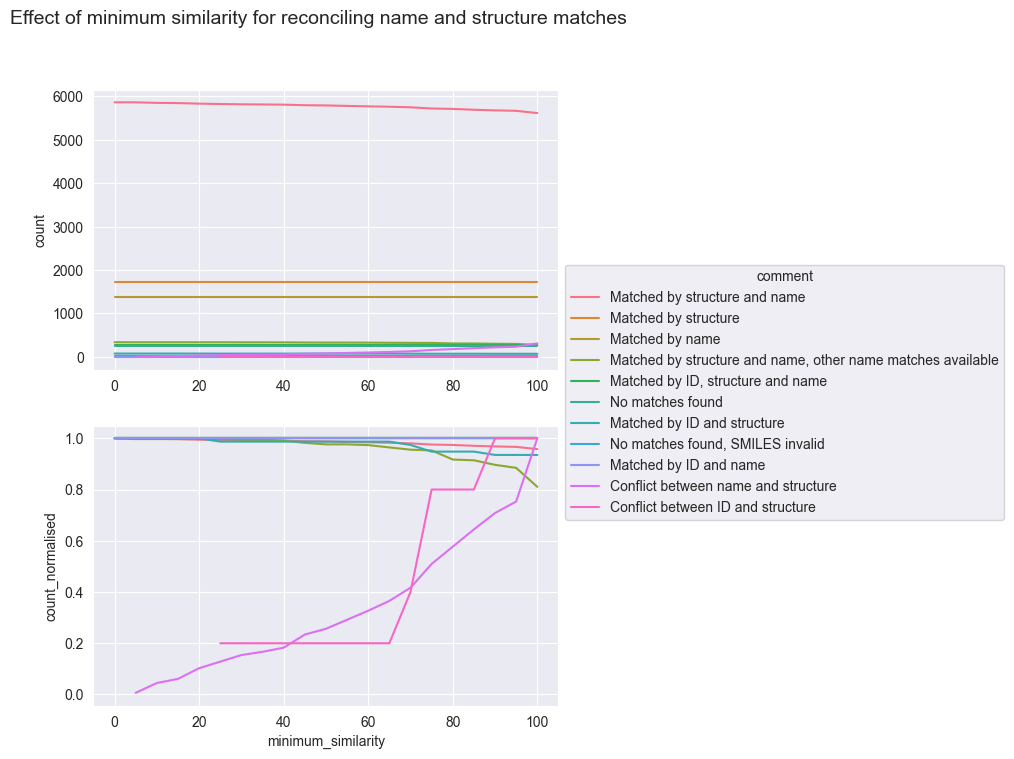

In [11]:
percent_step = 5
df_ms_comments = pd.DataFrame()
for min_sim in range(0, 100+percent_step, percent_step):
    _df = df_all.apply(axis="columns", result_type="expand", func=lambda x: resolve_pubchem_id(x.pubchem_compound_by_id, x.pubchem_compound_by_structure, x.pubchem_compounds_by_name, x.smiles, minimum_similarity=min_sim/100))[1].value_counts().to_frame()
    _df["minimum_similarity"] = min_sim
    df_ms_comments = pd.concat([df_ms_comments, _df])
    #print(min_sim)
df_ms_comments = df_ms_comments.reset_index().rename(columns={1:"comment"})
_d_comment_max_count = df_ms_comments.groupby("comment")["count"].agg("max").to_dict()
df_ms_comments["count_normalised"] = df_ms_comments.apply(axis="columns", func=lambda x: x["count"] / _d_comment_max_count[x["comment"]])

fig, axs = plt.subplots(2, 1, figsize = [6, 8])
ax = sns.lineplot(df_ms_comments, x="minimum_similarity", y="count", hue="comment", ax=axs[0])
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 0.4))
ax.set_xlabel("")
ax = sns.lineplot(df_ms_comments, x="minimum_similarity", y="count_normalised", hue="comment", ax=axs[1], legend=False)
_ = fig.suptitle("Effect of minimum similarity for reconciling name and structure matches", size=14)

In [12]:
df_all[["pubchem_cid", "pubchem_cid_matching_comment"]] = df_all.progress_apply(axis="columns", result_type="expand", func=lambda x: resolve_pubchem_id(x.pubchem_compound_by_id, x.pubchem_compound_by_structure, x.pubchem_compounds_by_name, x.smiles, minimum_similarity=0.8))
df_all.pubchem_cid_matching_comment.value_counts()

100%|██████████| 9923/9923 [00:00<00:00, 22061.21it/s]


pubchem_cid_matching_comment
Matched by structure and name                                  5714
Matched by structure                                           1723
Matched by name                                                1373
Matched by structure and name, other name matches available     310
Matched by ID, structure and name                               281
No matches found                                                241
Conflict between name and structure                             180
Matched by ID and structure                                      73
No matches found, SMILES invalid                                 20
Conflict between ID and structure                                 4
Matched by ID and name                                            4
Name: count, dtype: int64

In [13]:
assert len(df_all[pd.isna(df_all.smiles_sanitised) & pd.isna(df_all.pubchem_cid) & pd.notna(df_all.CID)]) < 50, "It should be very uncommon for B3DB to provide CID when this method cannot resolve it due to SMILES sanitisation. Those should be limited to There are 4 cases in R27 (LightBBB) where it seems like are multiple SMILES in the relevant field. Further cases should be related to what seems like manual direct matches (e.g. by adjusting the name of the compound) and CIDs in the CID1<NO> format."  # Previous iteration # == 55
assert len(df_all[pd.isna(df_all.pubchem_cid)]) <= len(df_all[pd.isna(df_all.CID)]) , "Given normalisation, the method should able to reconcile at least as many PubChem IDs as B3DB paper"
assert len(df_all[(df_all.pubchem_cid != df_all.CID) & pd.notna(df_all.CID) & (df_all.pubchem_cid_matching_comment == NO_MATCH_FOUND_INVALID_SMILES)]) == 0
assert len(df_all[(df_all.pubchem_cid != df_all.CID) & pd.notna(df_all.CID) & (df_all.pubchem_cid_matching_comment == NO_MATCH_FOUND)]) == 1, "There is a single case (R7:16) where B3DB authors mapped the compound manually. In the previous iteration #=7 - there are 2 cases where we the assignment of the original CID is unclear and 4 cases from R27 where the row data seems to contain multiple formulas."

## ChEMBL "parent" extraction 

At this stage we have the initial resolved CIDs from the raw records. 
In this step, as per the B3DB paper, we leverage the ChEMBL pipeline to extract "parent" compounds based on the SMILES from the resolved CIDs (where present) and sanitised_smiles (where CIDs are not available).  

### PubChem SMILES canonicalisation
PubChem SMILES canonicalisation process is not compatible with ChEMBL. For example, Morphine's (https://pubchem.ncbi.nlm.nih.gov/compound/5288826) SMILES (both canonical and isomeric) do not match the diagram exactly and are modified by ```chembl_structure_pipeline.get_parent_mol```. In ChEMBL, Morphine (CHEMBL70) has no parent. This is remedied by using PubChem's SDF files which preserve the structure. 

In [14]:
PUBCHEM_SPACIAL_DATA_SHELF_PATH = os.path.join(os.getcwd(), "caches", "pubchem_compound_spacial_data_shelf")
def get_pubchem_compound_spacial_data(cid, shelf_path=PUBCHEM_SPACIAL_DATA_SHELF_PATH):
    cid = str(cid)
    with shelve.open(shelf_path) as shelf:
        if cid not in shelf:        
            url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{cid}/record/SDF"
            res = get_pubchem_session().get(url)
            res.raise_for_status()
            shelf[cid] = res.content
        return shelf[cid]
    

def smiles_from_pubchem_spacial_data(cid):
    if pd.isna(cid):
        return None
    cid = str(int(cid))
    sdf = get_pubchem_compound_spacial_data(cid)
    with datamol.without_rdkit_log():
        mol = rdkit.Chem.MolFromMolBlock(sdf)
    return rdkit.Chem.MolToSmiles(mol)

df_all["smiles_pubchem"] = df_all["pubchem_cid"].progress_apply(smiles_from_pubchem_spacial_data)

100%|██████████| 9923/9923 [00:03<00:00, 2861.85it/s]


In [15]:
# Deduplicate by name.
# In the case of ~60 compound names, some of the hits are mapped to multiple CIDs due to their respective structure matches. In such cases we unify these records to the top name match.
_df_name_x_cids = df_all[pd.notna(df_all.pubchem_compounds_by_name) & pd.notna(df_all.pubchem_cid)].groupby("compound_name_cleaned").agg({
    "pubchem_cid": lambda x: list(dict.fromkeys(x)),
    "pubchem_cid_matching_comment": lambda x: list(dict.fromkeys(x)),
    "smiles_pubchem": lambda x: list(dict.fromkeys(x)),
    "pubchem_compounds_by_name": lambda x: list(x),
})
_df_name_x_cids = _df_name_x_cids[_df_name_x_cids.pubchem_cid.apply(len) > 1]

_df_name_x_cids["top_name_hit_smiles"] = _df_name_x_cids["pubchem_compounds_by_name"].apply(lambda x: smiles_from_pubchem_spacial_data(x[0][0]["CID"]))

_df_name_x_cids["distances"] = _df_name_x_cids.apply(axis="columns", func=lambda x: [get_tanimoto_distance(x.top_name_hit_smiles, y) for y in x.smiles_pubchem])
conflicting_name_to_top_hit_smiles = dict(_df_name_x_cids[_df_name_x_cids.distances.apply(lambda x: all(y >= 1 for y in x))].reset_index()[["compound_name_cleaned", "top_name_hit_smiles"]].itertuples(index=False))
df_all["smiles_pubchem"] = df_all.apply(axis="columns", func=lambda x: conflicting_name_to_top_hit_smiles.get(x.compound_name_cleaned, x.smiles_pubchem))

In [16]:
df_all[["smiles_parent", "chembl_pipeline_excluded"]] = df_all.progress_apply(
    axis="columns", 
    result_type="expand",
    func=lambda x: chembl_parent_from_smiles(x["smiles_pubchem"] if pd.notna(x["smiles_pubchem"]) else x["smiles_sanitised"] if (pd.notna(x["smiles_sanitised"]) and x["pubchem_cid_matching_comment"] not in {CONFLICT_BETWEEN_ID_AND_STRUCTURE, CONFLICT_BETWEEN_ID_AND_NAME, CONFLICT_BETWEEN_NAME_AND_STRUCTURE}) else None
))
#df_all["pubchem_compound_by_parent_structure"] = df_all["smiles_parent"].progress_apply(get_pubchem_compound_by_smiles)
#df_all["pubchem_cid_parent"] = df_all["pubchem_compound_by_parent_structure"].apply(lambda x: x["CID"] if pd.notna(x) else None)
# Multiple smiles_parent may resolve to the same pubchem_compound_by_parent_structure. We therefore obtain the detailed structure of the resulting pubchem_cid_parent. E.g. 'NC(N)=Nc1nc(CSCC/C(N)=N/S(N)(=O)=O)cs1' and 'NC(N)=Nc1nc(CSCCC(N)=NS(N)(=O)=O)cs1' both resolving in Famotidine.
#df_all["smiles_parent_pubchem"] = df_all.pubchem_cid_parent.progress_apply(smiles_from_pubchem_spacial_data)

100%|██████████| 9923/9923 [00:10<00:00, 962.54it/s] 


## InChI resolution
InChI and InChIKeys are not unique across PubChem compounds.
E.g.  ```get_pubchem_compound_information("inchikey", "KLWGWDOTUDKLKT-VIFPVBQESA-N")``` will return multiple results. Those will share InChI - hence this is not the case of a hash collision. We have found 3 such cases in this dataset, the other two KLWGWDOTUDKLKT-UHFFFAOYSA-N, JBKPUQTUERUYQE-UHFFFAOYSA-O. PubChem API tends to return a single compound for InChI and multiple entries for InChiKey. 
In this step, we reconcile multiple records sharing the same InChI. 

In [17]:
with datamol.without_rdkit_log():
    df_all["inchi_parent"] = df_all.smiles_parent.apply(lambda x: rdkit.Chem.MolToInchi(smiles_to_mol(x)) if pd.notna(x) else None)

In [18]:
def _resolve_from_inchi_or_smiles(inchi, smi):
    if pd.isna(inchi):
        return None
    res = get_pubchem_compound_information("inchi", inchi)
    if (not res) and pd.notna(smi):
        return get_pubchem_compound_by_smiles(smi)
    if res:
        return res[0]

df_all["pubchem_compound_resolved"] = df_all.progress_apply(axis="columns", func = lambda x: _resolve_from_inchi_or_smiles(x.inchi_parent, x.smiles_parent))
df_all["pubchem_compound_resolved"] = df_all["pubchem_compound_resolved"].progress_apply(lambda x: x | {"spacial_data_smiles": smiles_from_pubchem_spacial_data(x["CID"])} if pd.notna(x) else None)

100%|██████████| 9923/9923 [00:03<00:00, 3058.94it/s]


In [19]:
# There are cases where we cannot resolve parent's PubChem id, but the original records is reconcilable.
#assert len(df_all[(pd.notna(df_all.pubchem_cid)) & (pd.isna(df_all.pubchem_compound_by_parent_structure))]) == 20

#df_all["pubchem_compound_resolved"] = df_all.apply(axis="columns", func=lambda x: x.pubchem_compound_by_parent_structure if pd.notna(x.pubchem_compound_by_parent_structure) else  get_pubchem_compound_information("cid", str(int(x.pubchem_cid)))[0] if pd.notna(x.pubchem_cid) else None)
# Adds spacial-data based SMILES. Uses a different naming convention to distinguish between PubChem-supplied and injected data.
#df_all["pubchem_compound_resolved"] = df_all["pubchem_compound_resolved"].apply(lambda x: x | {"spacial_data_smiles": smiles_from_pubchem_spacial_data(x["CID"])} if pd.notna(x) else None)

assert df_all.pubchem_compound_resolved.apply(lambda x: str(x) if pd.notna(x) else None).nunique() == df_all.pubchem_compound_resolved.apply(lambda x: x["CID"] if pd.notna(x) else None).nunique(), "Different calls for PubChem compound information should contain exactly the same data"

In [20]:
_df_counts = df_all[["CID", "cid_cleaned", "smiles", "smiles_sanitised", "compound_name", "compound_name_cleaned", "pubchem_cid", "smiles_parent", "inchi_parent", "pubchem_compound_resolved"]].copy()
#_df_counts["pubchem_compound_by_parent_structure"] = _df_counts.pubchem_compound_by_parent_structure.apply(lambda x: str(x) if pd.notna(x) else None)
_df_counts["pubchem_compound_resolved"] = _df_counts.pubchem_compound_resolved.apply(lambda x: str(x) if pd.notna(x) else None)
_u = _df_counts.nunique().to_frame().rename(columns={0: "Unique"})
_t = _df_counts.notna().sum().to_frame().rename(columns={0: "Total non-empty"}) 
print(f"Fields statistics of {len(_df_counts)} records:")
print(_u.join(_t))


Fields statistics of 9923 records:
                           Unique  Total non-empty
CID                          3561             8583
cid_cleaned                   362              362
smiles                       6979             9521
smiles_sanitised             4072             8644
compound_name                5638             9414
compound_name_cleaned        5359             8878
pubchem_cid                  3564             9478
smiles_parent                3508             9698
inchi_parent                 3502             9698
pubchem_compound_resolved    3411             9566


In [21]:
print("Initial cid_cleaned / smiles_sanitised / compound_name_cleaned to PubChem resolution statistics - records that differ between this and original work")
print(df_all[(df_all.pubchem_compound_resolved.apply(lambda x: x["CID"] if pd.notna(x) else None) != df_all.CID) & pd.notna(df_all.CID)].pubchem_cid_matching_comment.value_counts())

Initial cid_cleaned / smiles_sanitised / compound_name_cleaned to PubChem resolution statistics - records that differ between this and original work
pubchem_cid_matching_comment
Matched by structure and name                                  1045
Conflict between name and structure                             142
Matched by structure and name, other name matches available     122
Matched by ID and structure                                      25
Matched by name                                                  19
Matched by structure                                             19
Matched by ID, structure and name                                 5
Conflict between ID and structure                                 4
Matched by ID and name                                            3
No matches found                                                  1
Name: count, dtype: int64


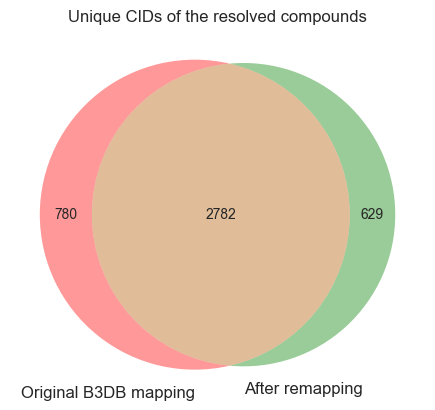

In [47]:
_, ax = plt.subplots(1, 1)
venn2(
    [set(df_all.CID.unique()), set(cid for cid in df_all.pubchem_compound_resolved.apply(lambda x: x["CID"] if pd.notna(x) else None) if pd.notna(cid))],
    ["Original B3DB mapping", "After remapping"],
    ax=ax
    
)
_ = ax.set_title("Unique CIDs of the resolved compounds")

In [23]:
_z  = df_all[(pd.notna(df_all.pubchem_compound_resolved)) & (pd.notna(df_all.pubchem_compounds_by_name))].groupby("compound_name_cleaned").pubchem_compound_resolved.apply(lambda x: set(y["CID"] for y in x)).to_frame()
assert len(_z[_z.pubchem_compound_resolved.apply(len) > 1]) == 4, "(Almost) all should resolve to a single parent molecule"
assert df_all[df_all.compound_name_cleaned.apply(lambda x: str(x).lower() == "morphine" if pd.notna(x) else False)].pubchem_compound_resolved.apply(lambda x: x["CID"] if pd.notna(x) else None).nunique() == 1, "Morphine should be represented by a single CID"

In [24]:
df_records_resolved = df_all[["record_id", "cid_cleaned", "smiles_sanitised", "compound_name_cleaned", "logBB_cleaned", "BBB+/BBB-_cleaned", "pubchem_compound_by_id", "pubchem_compound_by_structure", "pubchem_compounds_by_name", "pubchem_cid", "pubchem_cid_matching_comment", "smiles_pubchem", "smiles_parent", "inchi_parent", "chembl_pipeline_excluded", "pubchem_compound_resolved"]]
df_records_resolved.to_csv("dataset_intermediaries/01_records_resolved.csv", index=False)

In [25]:
df_records_resolved = pd.read_csv("dataset_intermediaries/01_records_resolved.csv", low_memory=False)[["record_id", "compound_name_cleaned", "logBB_cleaned", "BBB+/BBB-_cleaned", "smiles_parent", "inchi_parent", "chembl_pipeline_excluded", "pubchem_compound_resolved"]]
#df_records_resolved["pubchem_compound_resolved"] = df_records_resolved["pubchem_compound_resolved"].apply(lambda x: eval(x) if pd.notna(x) else None)

assert sum(df_records_resolved.groupby("inchi_parent").pubchem_compound_resolved.apply(lambda x: len(set(x))) > 1) == 0, "There should always be up to one resolved compound per parent InChI"

print(f"Loaded {len(df_records_resolved)} resolved records")

Loaded 9923 resolved records


## Grouping.
In this section we will use the resolved records to generate compound permeability data. 

In [26]:
_df_discarded_not_resolved_no_parent = df_records_resolved[pd.isna(df_records_resolved.pubchem_compound_resolved) & pd.isna(df_records_resolved.inchi_parent)]
print(f"{len(_df_discarded_not_resolved_no_parent)} records are discarded as they could not be reliably mapped to a PubChem entry.")
if "df_all" in globals():
    print(f"This includes {len(df_all[(pd.isna(df_all.pubchem_compound_resolved)) & pd.isna(df_all.inchi_parent) & (df_all.pubchem_cid_matching_comment == CONFLICT_BETWEEN_NAME_AND_STRUCTURE)])} cases of '{CONFLICT_BETWEEN_NAME_AND_STRUCTURE}' during the initial record resolution")

_s = set(_df_discarded_not_resolved_no_parent.record_id)
df_resolved = df_records_resolved[df_records_resolved.record_id.apply(lambda x: x not in _s)]
print(f"{len(df_resolved)} records remaining")

225 records are discarded as they could not be reliably mapped to a PubChem entry.
This includes 179 cases of 'Conflict between name and structure' during the initial record resolution
9698 records remaining


In [27]:
# Analysis of compounds excluded by ChEMBL pipeline point to vitamin B12 (cobalt) and carboplatin (a chemotherapy medication containing platinum) and Gadodiamine (a gadolinium based contrast agent). As per the original work, these are removed.

_df_discarded_excluded_by_chembl_pipeline = df_records_resolved[df_records_resolved.chembl_pipeline_excluded == True]
assert len(_df_discarded_excluded_by_chembl_pipeline) == 3, f"There should be 3 compound excluded by ChEMBL pipeline, found {len(_df_discarded_excluded_by_chembl_pipeline)}"
_s = set(_df_discarded_excluded_by_chembl_pipeline.record_id)

print(f"Removing {len(_s) if _s else 0} records excluded in ChEMBL pipeline")
df_resolved = df_resolved[df_resolved.record_id.apply(lambda x: x not in _s)]

print(f"Removing records with invalid parent_smiles. This should be one record (on the full dataset) where valence sanitisation would result in splitting it.")
with datamol.without_rdkit_log():
    df_resolved = df_resolved[df_resolved.smiles_parent.apply(lambda x: True if pd.isna(x) or pd.notna(rdkit.Chem.MolFromSmiles(x)) else False)]
print(f"{len(df_resolved)} records remaining")

Removing 3 records excluded in ChEMBL pipeline
Removing records with invalid parent_smiles. This should be one record (on the full dataset) where valence sanitisation would result in splitting it.
9695 records remaining


In [28]:
df_grouped = df_resolved.groupby("inchi_parent").agg({
    "record_id": list,
    "compound_name_cleaned": lambda x: list(filter(lambda y: pd.notna(y), dict.fromkeys(x))),  # Unique non-null records in the order of appearance.
    "logBB_cleaned": list,
    "BBB+/BBB-_cleaned": list,
    "smiles_parent": lambda x: list(dict.fromkeys(x)),
    "pubchem_compound_resolved": lambda x: list(filter(lambda y: pd.notna(y), dict.fromkeys(x))),
}).reset_index()
assert sum(df_grouped.pubchem_compound_resolved.apply(len) > 1) == 0, "There should be up to one resolved PubChem compound per InChI"
df_grouped["pubchem_compound_resolved"] = df_grouped.pubchem_compound_resolved.apply(lambda x: x[0] if x else None)
assert df_grouped.smiles_parent.apply(len).value_counts()[2] == 6, "There are 6 cases of multiple parent_smiles by InChI, including 1 of 3 different SMILES. In these cases, all SMILES should be equivalent. Previous #=15."
df_grouped.smiles_parent = df_grouped.smiles_parent.apply(lambda x: x[0]) 
print(f"Grouped {len(df_resolved)} resolved records into {len(df_grouped)} molecules by InChI")

Grouped 9695 resolved records into 3499 molecules by InChI


#### LogBB values resolution from multiple records
We follow the original work including the exclusion criteria and 

In [29]:
LOGBB_MIN_VALUE = -9
LOGBB_MAX_RANGE = 1

RESOLUTION_NO_LOGBB_VALUES = "No LogBB values"
RESOLUTION_NO_LOGBB_ABOVE_MIN_VALUE = f"No LogBB values above minimum threshold ({LOGBB_MIN_VALUE})"
RESOLUTION_LOGBB_RANGE_ABOVE_THRESHOLD = f"LogBB values range above threshold ({LOGBB_MAX_RANGE})"
RESOLUTION_LOGBB_GROUP_A = "LogBB group A"
RESOLUTION_LOGBB_GROUP_B = "LogBB group B"
RESOLUTION_LOGBB_GROUP_B1 = "LogBB group B1"
RESOLUTION_LOGBB_GROUP_C = "LogBB group C"
RESOLUTION_LOGBB_GROUP_D = "LogBB group D"
RESOLUTION_LOGBB_FAILED_TO_CATEGORISE = "Failed to categorise LogBB values"

def _resolve_log_bb(logbb_vals):
    logbb_vals = [v for v in logbb_vals if pd.notna(v)]
    if len(logbb_vals) == 0:
        return None, RESOLUTION_NO_LOGBB_VALUES
    # The original work excludes all logBB values below -9. All those are present in R25, where authors place them on their "controversial" list, and excluded from modelling. Note - there are no values present between (-9, -3).
    logbb_vals = [round(v, 2) for v in logbb_vals if v > LOGBB_MIN_VALUE]
    if len(logbb_vals) == 0:
        return None, RESOLUTION_NO_LOGBB_ABOVE_MIN_VALUE
    if max(logbb_vals) - min(logbb_vals) > LOGBB_MAX_RANGE:
        return None, RESOLUTION_LOGBB_RANGE_ABOVE_THRESHOLD
    
    # Group A - A single value
    if len(logbb_vals) == 1:
        return logbb_vals[0], RESOLUTION_LOGBB_GROUP_A
    mean = statistics.mean(logbb_vals)
    std =  statistics.stdev(logbb_vals)   
    # Group B - All values are within 5% of the mean
    if all([abs(v - mean) < abs(0.05 * mean) for v in logbb_vals]) or (abs(mean)<=0.05 and all( abs(v) < 0.05 for v in logbb_vals )): # This is an extension for 2 molecules with mean of 0.0
        return mean, RESOLUTION_LOGBB_GROUP_B
        
    # Group B1 - At least 80% of values are within 0.1 + standard deviations from the mean  
    if (sum([abs(v - mean) < (0.05 + 0.25*std) for v in logbb_vals]) / len(logbb_vals)) >= 0.8: # This is an extension for 2 molecules with mean of 0.0
       return mean, RESOLUTION_LOGBB_GROUP_B1
            
    # Group C - 2 values.
    if len(logbb_vals) == 2:
        return mean, RESOLUTION_LOGBB_GROUP_C
    
    # Group D - a single most common value exists.
    most_common = collections.Counter(logbb_vals).most_common()
    if len(most_common) == 1 or most_common[0][1] > most_common[1][1]:  # A single mode / most common value.
        return most_common[0][0], RESOLUTION_LOGBB_GROUP_D
    
    return None, RESOLUTION_LOGBB_FAILED_TO_CATEGORISE
    
df_grouped[["logBB_resolved", "logBB_resolution_comment"]] = df_grouped.apply(axis="columns", func=lambda x: _resolve_log_bb(x.logBB_cleaned), result_type="expand")
print(f"Resolved logBB values for {sum(pd.notna(df_grouped.logBB_resolved))} compounds out of {len(df_grouped)}.")
df_grouped.logBB_resolution_comment.value_counts().sort_index()

Resolved logBB values for 950 compounds out of 3499.


logBB_resolution_comment
Failed to categorise LogBB values                  8
LogBB group A                                    386
LogBB group B                                    402
LogBB group B1                                    85
LogBB group C                                      8
LogBB group D                                     69
LogBB values range above threshold (1)            13
No LogBB values                                 2516
No LogBB values above minimum threshold (-9)      12
Name: count, dtype: int64

In [30]:
THRESHOLD_LOGBB = -1
BBB_P = "BBB+"
BBB_N = "BBB-"

RESOLUTION_BBB_CLASS_GROUP_A = "BBB+/BBB- group A"
RESOLUTION_BBB_CLASS_GROUP_B = "BBB+/BBB- group B"
RESOLUTION_BBB_CLASS_GROUP_C = "BBB+/BBB- group C"
RESOLUTION_BBB_CLASS_GROUP_D = "BBB+/BBB- group D"
RESOLUTION_BBB_NO_CLASS_ASSIGNED = "No BBB class assigned"
RESOLUTION_BBB_THRESHOLD_INCONSISTENT_RESULTS = f"Inconsistent results at {THRESHOLD_LOGBB} logBB threshold"
RESOLUTION_BBB_NO_LABEL_PRESENT = "No BBB label present"

threshold_dict = {
    "R1": -1,
    "R2": (-2,-1),
    "R7": -1,
    "R8": 0,
    "R13": -1,
    "R16": -1,
    "R18": 0.1,
    "R19": -1,
    "R25": 0,
    "R28": -1,
}


#TODO start here
def _resolve_bbb_class(record_ids, bbb_values, logbb_resolved):
    assert len(bbb_values) > 0, "There should be at least a single BBB class supplied"
    
    # Group A - available logBB value
    if pd.notna(logbb_resolved):
        return BBB_P if logbb_resolved >= THRESHOLD_LOGBB else BBB_N , RESOLUTION_BBB_CLASS_GROUP_A
    
    thresholds = [threshold_dict.get(r.split(":")[0]) for r in record_ids]
    any_threshold_logbb_value = any(thresholds[i] == THRESHOLD_LOGBB for i, _ in enumerate(bbb_values))
    # TODO This logic attempts to emulate the original work but perhaps should be adjusted in light of discarding some BBB+/BBB- values when not provided in the datasource. 
    non_null_vals = list(set(v for v in bbb_values if pd.notna(v))) 
    if len(non_null_vals) == 1:
        return non_null_vals[0], RESOLUTION_BBB_CLASS_GROUP_B if any_threshold_logbb_value else RESOLUTION_BBB_CLASS_GROUP_C
    else:
        values_at_threshold = [v for i, v in enumerate(bbb_values) if thresholds[i] == THRESHOLD_LOGBB]
        if len(set(values_at_threshold)) > 1:
            return None, RESOLUTION_BBB_THRESHOLD_INCONSISTENT_RESULTS
        
        most_common = collections.Counter(v for v in bbb_values if pd.notna(v)).most_common()
        if len(most_common) == 0:
            return None, RESOLUTION_BBB_NO_LABEL_PRESENT
        if len(most_common) == 1 or most_common[0][1] > most_common[1][1]:  # A single mode / most common value.
            return most_common[0][0], RESOLUTION_BBB_CLASS_GROUP_D
        
    return None, RESOLUTION_BBB_NO_CLASS_ASSIGNED 
    
df_grouped[["BBB+/BBB-_resolved", "BBB+/BBB-_resolution_comment"]] = df_grouped.apply(axis="columns", func=lambda x: _resolve_bbb_class(x.record_id, x["BBB+/BBB-_cleaned"], x.logBB_resolved), result_type="expand")
print(f'Resolved BBB class for {sum(pd.notna(df_grouped["BBB+/BBB-_resolved"]))} compounds out of {len(df_grouped)}.')
df_grouped["BBB+/BBB-_resolution_comment"].value_counts().sort_index()

Resolved BBB class for 3414 compounds out of 3499.


BBB+/BBB-_resolution_comment
BBB+/BBB- group A         950
BBB+/BBB- group C        2394
BBB+/BBB- group D          70
No BBB class assigned      57
No BBB label present       28
Name: count, dtype: int64

In [31]:
assert len(df_grouped[df_grouped.logBB_resolved.apply(lambda x: pd.notna(x) and x < -1) & (df_grouped["BBB+/BBB-_cleaned"].apply(lambda x: "BBB+" in x))]) <= 27, "There is a limited number of cases of logBB<1 where some records indicate BBB+, previous #=24"

assert len(df_grouped[df_grouped.logBB_resolved.apply(lambda x: pd.notna(x) and x >= -1) & (df_grouped["BBB+/BBB-_cleaned"].apply(lambda x: "BBB-" in x))]) <= 374, "There is a limited number of cases of logBB>-1 where some records indicate BBB-"

assert len(df_grouped[df_grouped["BBB+/BBB-_resolution_comment"] == RESOLUTION_BBB_NO_LABEL_PRESENT]) <= 28, f"There are some 17 records from R26 where logBB is not provided while the original work asserts them as BBB+, in addition there are 6 compounds where all provided logBB values are less than {LOGBB_MIN_VALUE}"
# TODO the above should be 27 not 28, verify the difference.


assert len(df_grouped[df_grouped["BBB+/BBB-_resolution_comment"] == RESOLUTION_BBB_THRESHOLD_INCONSISTENT_RESULTS]) <= 42, f"There are 42 compounds with conflicting labels coming from resources that report using threshold of {THRESHOLD_LOGBB}"

In [32]:
df_grouped.pubchem_compound_resolved = df_grouped.pubchem_compound_resolved.apply(lambda x: x if type(x) != str else eval(x))
df_grouped["cid"] = df_grouped.pubchem_compound_resolved.apply(lambda x: x.get("CID") if pd.notna(x) else None)
assert df_grouped.cid.nunique() == len(df_grouped[pd.notna(df_grouped.pubchem_compound_resolved)]), "CIDs should be unique among all PubChem resolved compound"


conflicting_spacial_smiles = {
    "CC1=C/[C@@H](O)CC(=O)Cc2nc(co2)C(=O)N2CCC=C2C(=O)O[C@@H](C(C)C)[C@@H](C)/C=C\C(=O)NC/C=C\\1", # There are 2 distinct PubChem compounds: 92043180 and 122362102 that both point to the same 3D structure.
}
def _resolve_smiles(row):
    if pd.notna(row.pubchem_compound_resolved):
        if row.pubchem_compound_resolved["spacial_data_smiles"] not in conflicting_spacial_smiles:
            return row.pubchem_compound_resolved["spacial_data_smiles"]
        else:
            return row.pubchem_compound_resolved["IsomericSMILES"]
    else:
        return row.smiles_parent
    
df_grouped["smiles_resolved"] = df_grouped.apply(axis="columns", func=_resolve_smiles)
assert df_grouped.smiles_resolved.nunique() == len(df_grouped), "Resolved SMILES should be unique among all compounds"
df_grouped["iupac_name"] = df_grouped.pubchem_compound_resolved.apply(lambda x: x["IUPACName"] if pd.notna(x) and "IUPACName" in x else None)


In [33]:
df_grouped["names"] = df_grouped.apply(axis="columns", func=lambda x: list(dict.fromkeys(x.compound_name_cleaned + ([x.pubchem_compound_resolved["Title"]] if pd.notna(x.pubchem_compound_resolved) and "Title" in x.pubchem_compound_resolved else []))) )
def _resolve_names(names):
    lc_names = {}
    for n in names:
        if n.lower() not in lc_names:
            lc_names[n.lower()] = []
        lc_names[n.lower()].append(n)
    rv = []
    for n, vals in lc_names.items():
        rv.append(vals[0].title())
    return rv
df_grouped["names_resolved"] = df_grouped.names.apply(_resolve_names)             

In [34]:
_df = df_grouped[["inchi_parent", "record_id", "smiles_resolved", "cid", "iupac_name", "names_resolved", "logBB_resolved", "logBB_resolution_comment", "BBB+/BBB-_resolved", "BBB+/BBB-_resolution_comment"]].copy()
_df["record_id"] = _df.record_id.apply(lambda x: "|".join(x))
_df["names_resolved"] = _df.names_resolved.apply(lambda x: "|".join(x))
_df.to_csv("dataset_intermediaries/02_grouped.csv", index=False)

## Dataset generation
In this section, the grouped records are converted to an actionable dataset: the entries where BBB+/BBB- classification could not be produced are removed and the columns are reformatted to adhere to the original B3DB. 
We produce a single dataset (without splitting to classification and regression) - it contains both BBB+/BBB- labels and logBB value - similar to the original classification dataset. It is possible to generate a regression dataset by filtering for non-null values in the lobBB column. 

In [35]:
df_grouped = pd.read_csv("dataset_intermediaries/02_grouped.csv")
print(f"Loaded {len(df_grouped)} grouped records")

Loaded 3499 grouped records


In [36]:
df_grouped_filtered = df_grouped[pd.notna(df_grouped["BBB+/BBB-_resolved"])].copy()
print(f"Removed {len(df_grouped) - len(df_grouped_filtered)} grouped entries as it was impossible to determine BBB+/BBB- class")

Removed 85 grouped entries as it was impossible to determine BBB+/BBB- class


In [37]:
df_grouped_filtered["logBB_group"] = df_grouped_filtered["logBB_resolution_comment"].apply(lambda x: x.replace("LogBB group ", "") if "LogBB group " in x else None)
df_grouped_filtered["BBB+/BBB-_group"] = df_grouped_filtered["BBB+/BBB-_resolution_comment"].apply(lambda x: x.replace("BBB+/BBB- group ", ""))
assert sum(pd.isna(df_grouped_filtered["BBB+/BBB-_group"])) == 0
assert pd.notna("logBB_group") == pd.notna("logBB")

In [38]:
df_b3db_kc = df_grouped_filtered[["inchi_parent", "names_resolved", "iupac_name", "smiles_resolved", "cid", "record_id", "logBB_resolved", "logBB_group", "BBB+/BBB-_resolved", "BBB+/BBB-_group"]].rename(columns={
    "inchi_parent": "inchi",
    "names_resolved": "names",
    "record_id": "record_ids",
    "smiles_resolved": "smiles",
    # "names_resolved": "names",
    # "record_id": "record_ids",
    "logBB_resolved": "logBB",
    "BBB+/BBB-_resolved": "BBB+/BBB-",
})
df_b3db_kc.cid = df_b3db_kc.cid.apply(lambda x: str(int(x)) if pd.notna(x) else "") # A conversion from nullable float to int-based string. It should automatically be parsed to the 
df_b3db_kc.to_csv(
    "dataset_intermediaries/03_b3db_kc_raw.tsv", 
    index=False, 
    sep="\t",
    float_format="%.2f" # "logBB" ought to be the sole float column. 
)

### Reference data statistics

In [58]:
records_in_b3db_kc = df_b3db_kc.record_ids.apply(lambda x: {y.split("_")[0] for y in x.split("|")})

_d = [{
    "id": rd,
    "author_year": references_id_to_first_author_year[rd],
    "# original": len(get_b3db_r_df(rd)),
    "# in dataset": len([x for x in records_in_b3db_kc if rd in x]),
    "# only source": len([x for x in records_in_b3db_kc if rd in x and len(x) == 1]),    
} for rd in references_used]

pd.DataFrame(_d)

,id,author_year,# original,# in dataset,# only source
0,R3,abraham_2006,328,272,3
1,R4,mente_2005,189,187,10
2,R5,guerra_2008,108,106,0
3,R6,adenot_2004,1692,1608,1070
4,R7,andres_2006,224,220,3
5,R12,garg_2006,182,174,1
6,R14,ghose_2012,942,855,186
7,R17,fu_2008,55,55,0
8,R21,muehlbacher_2011,362,351,4
9,R22,clark_1999,27,27,0


## Fingerprints conflicts and aggregators

During fingerprint analysis, we have noticed that over 63% (72/116) of conflicts in scaffold labels in our resulting dataset is caused by entries coming only from R27. We have further looked into this dataset and realised it is an aggregator, merging 8 datasets, 6 of which are included in B3DB, one is MoleculeNet (which should be equivalent to R1) and Yuan 2018.

Gathering further statistics on the contents of R27:
Total compounds with BBClass            : 7162
Total compounds with logBB values       : 1155
Total unique compounds with BBClass     : 4567
Total unique compounds with logBB values: 749
Multiple BBClass conflicts              : 224  (within the dataset)

## R13 and R24
Iterating on the conflict we have noticed R13 (Wang 2018) and R24 (Roy 2019) are resposible for the majority of the other fingerprint - based conflicts.

>It may be beneficial to remove the aggregators and rely instead on the original publications and datasets. Removal of R13, R24 and R27 should require adding 3 new datasets (Shen 2010, Yuan 2018, Doniger 2002).


In [ ]:
print("R27 / LightBBB dataset statistics")

df_r27 = pd.read_csv("../data/LightBBB_dataset/y_test_indices.csv").rename(columns={"Unnamed: 0": "SMILES"})
print("Total compounds with BBClass            :", len(df_r27.BBclass))
print("Total compounds with logBB values       :", len(df_r27[pd.notna(df_r27.logBB)]))
df_r27["mol"]=df_r27.SMILES.apply(smiles_to_mol)
df_r27["smiles_normalised"]=df_r27.mol.apply(rdkit.Chem.MolToSmiles)
df_r27_grouped = df_r27.groupby("smiles_normalised").agg({
    "BBclass": list,
    "logBB": list,
    "SMILES": list,
})

print("Total unique compounds with BBClass     :", len(df_r27_grouped.BBclass))
print("Total unique compounds with logBB values:", len(df_r27[pd.notna(df_r27.logBB)].groupby("smiles_normalised")))
df_r27_grouped_bbb_conflicts = df_r27_grouped[df_r27_grouped.BBclass.apply(set).apply(len) > 1].copy()
print("Multiple BBClass conflicts              :", len(df_r27_grouped_bbb_conflicts))

#df_r27_grouped.SMILES.apply(len).value_counts()
df_r27_grouped_bbb_conflicts["no_records"] = df_r27_grouped_bbb_conflicts.SMILES.apply(len)
df_r27_grouped_bbb_conflicts.sort_values("no_records", ascending=False)

In [ ]:
_df_kc_o = df_b3db_kc
print("Fingerprint conflict statistics in the context of aggregators3")
_df_kc_o["fingerprint"] = _df_kc_o.smiles.apply(_to_fingerprint_tuple)
df_fp_group = _df_kc_o.groupby("fingerprint").agg({
    "BBB+/BBB-": list,
    "logBB": list,
    "names": list,
    "cid": list,
    "record_ids": list,
    "smiles": list,
})
df_fp_group[df_fp_group["BBB+/BBB-"].apply(set).apply(len) > 1]
print("Total fingerprints with BBB+/BBB- conflicts:", len(df_fp_group[df_fp_group["BBB+/BBB-"].apply(set).apply(len) > 1]))

df_fp_group_no_27 = _df_kc[_df_kc.record_ids.apply(lambda x: len(list(y for y in x.split("|") if y[0:3] not in {"R27"})) > 0)].groupby("fingerprint").agg({
    "BBB+/BBB-": list,
    "logBB": list,
    "names": list,
    "cid": list,
    "record_ids": list,
    "smiles": list,
}) 
print("Total fingerprints with BBB+/BBB- conflicts excluding compounds sourced from a single R27 record:", len(df_fp_group_no_27[df_fp_group_no_27["BBB+/BBB-"].apply(set).apply(len) > 1]))

_s_fp_in_bbb_kc_no_27 = set(df_fp_group_no_27[(df_fp_group_no_27["BBB+/BBB-"].apply(set).apply(len) > 1)].index)

df_fp_group_r27_conflicts = df_fp_group[(df_fp_group["BBB+/BBB-"].apply(set).apply(len) > 1) & (df_fp_group.index.map(lambda x: x not in _s_fp_in_bbb_kc_no_27))]

df_fp_group_no_27_no_13_no_24 = _df_kc[_df_kc.record_ids.apply(lambda x: len(list(y for y in x.split("|") if y[0:3] not in {"R13", "R24", "R27"})) > 0)].groupby("fingerprint").agg({
    "BBB+/BBB-": list,
    "logBB": list,
    "names": list,
    "cid": list,
    "record_ids": list,
    "smiles": list,
}) 
print("Total fingerprints with BBB+/BBB- conflicts excluding compounds sourced from a single R13, R24 and R27 record:", len(df_fp_group_no_27_no_13_no_24[df_fp_group_no_27_no_13_no_24["BBB+/BBB-"].apply(set).apply(len) > 1]))
df_fp_group_no_27_no_13_no_24[df_fp_group_no_27_no_13_no_24["BBB+/BBB-"].apply(set).apply(len) > 1]
print(f"""
Effects of excluding entries coming from only R13, R24 and R27:
 - total compounds        : {len(df_fp_group.smiles.explode())} -> {len(df_fp_group_no_27_no_13_no_24.smiles.explode())}
 - fingerprints           : {len(df_fp_group)} -> {len(df_fp_group_no_27_no_13_no_24)} 
 - total with logBB       : {sum(pd.notna(df_fp_group.logBB.explode()))} -> {sum(pd.notna(df_fp_group_no_27_no_13_no_24.logBB.explode()))}
 - fingerprints with logBB: {sum(df_fp_group.logBB.apply(lambda x: len([y for y in x if pd.notna(y)]) > 0))}  -> {sum(df_fp_group_no_27_no_13_no_24.logBB.apply(lambda x: len([y for y in x if pd.notna(y)]) > 0))}
""")
